In [56]:
import re

import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pymorphy3 import MorphAnalyzer
from sklearn.model_selection import train_test_split
from typing import List
import torch
import torch.nn as nn
import torch.nn.functional as F

In [57]:
patterns = "[«»A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()

In [58]:
df_csv = pd.read_csv(r"C:\Users\natal\lab_2_python\annotation1.csv")
texts = []
for absolute_path, rating in zip(df_csv['absolute_path'], df_csv['rating']):
    with open(absolute_path, 'r', encoding='utf-8') as file:
        text = file.read()
        texts.append((text, rating))
        
df = pd.DataFrame(texts, columns=['review', 'rating'])

In [59]:
df['rating'] = df['rating'].replace({1: 0, 2: 1, 3: 2, 4: 3, 5: 4})
print(df)

                                                 review  rating
0     Архимаг ищет невесту\nМного читала академок, р...       0
1     Манюня\nВсё, что нужно знать об уровне юмора э...       0
2     Удивительный Александр и крылатые кошки\nПочем...       0
3     Бездушный принц\nЗахотелось прочитать какую-ни...       0
4     Душа осьминога. Тайны сознания удивительного с...       0
...                                                 ...     ...
5000  Спаси меня от холода ночи\nЖизнь деревни Каслд...       4
5001  Витаминка\nКаково это быть купидоном? Это волш...       4
5002  Цветок в мужской академии магии\nХотела бы рас...       4
5003  Господин Неудача\nПосле загадочной гибели роди...       4
5004  Кай\n"Прежде чем войти куда-то, убедись, что т...       4

[5005 rows x 2 columns]


In [61]:
def lemmatize(review: str) -> List[str]:
    """ excludes stop words, commas and brings words to a normal appearance

    Args:
        review (str): book review

    Returns:
        List[str]: a list with words
    """
    review = re.sub(patterns, ' ', review)
    tokens = nltk.word_tokenize(review.lower())
    preprocessed_text = []
    for token in tokens:
        lemma = morph.parse(token)[0].normal_form
        if lemma not in stopwords_ru:
            preprocessed_text.append(lemma)
    return preprocessed_text

In [62]:
df['review'] = df['review'].apply(lemmatize)
print(df.head())

                                              review  rating
0  [архимаг, искать, невеста, читать, академка, р...       0
1  [манюнить, всё, нужно, знать, уровень, юмор, к...       0
2  [удивительный, александр, крылатый, кошка, поч...       0
3  [бездушный, принц, захотеться, прочитать, нибы...       0
4  [душа, осьминог, тайна, сознание, удивительный...       0


In [63]:
def join_lemmatized_words(words_list: list) -> str:
    """ after lemmatization, we combine the words into a string for further processing
    Args:
        words_list (list): a list of reviews

    Returns:
        str: returns the review as a string
    """
    return ' '.join(words_list)

In [64]:
df['review'] = df['review'].apply(join_lemmatized_words)

In [88]:
vectorizer = CountVectorizer(max_features=15000)
sparse_matrix = vectorizer.fit_transform(df['review']).toarray()

x_train, x_test_valid, y_train, y_test_valid = train_test_split(sparse_matrix, np.array(df['rating']), test_size=0.2)
x_test, x_valid, y_test, y_valid = train_test_split(x_test_valid, y_test_valid, test_size=0.5)




In [66]:
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

{0: 799, 1: 813, 2: 799, 3: 799, 4: 794}


In [67]:
class LogisticRegression(nn.Module):
    def __init__(self):
        """
            the class constructor uses 3 nn.Linear layers from 15000 to 5
        """
        super(LogisticRegression, self).__init__()
        self.linear1 = nn.Linear(15000, 150)
        self.linear2 = nn.Linear(150, 15)
        self.linear3 = nn.Linear(15, 5) 

    def forward(self, x: torch.Tensor):
        """
                Forward pass of the logistic regression model.

                Args:
                x (torch.Tensor): The input tensor of shape (batch_size, 15000).
                
                Returns:
                torch.Tensor: representing the predicted probabilities of classes.
        """
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return F.softmax(x, dim=1) 


In [68]:
model = LogisticRegression()
criterion = nn.CrossEntropyLoss()
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()
x_valid = torch.from_numpy(x_valid).float()
y_valid = torch.from_numpy(y_valid).long()
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).long()

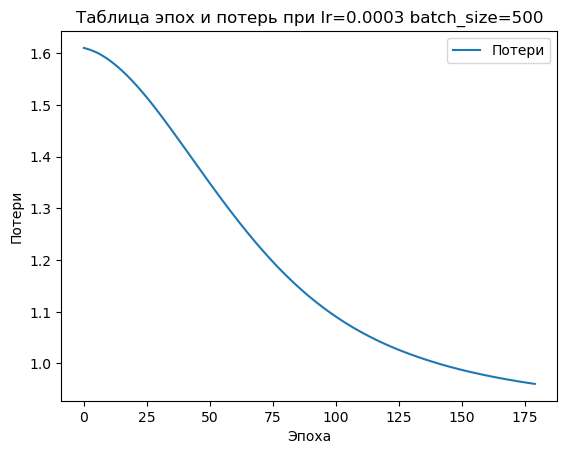

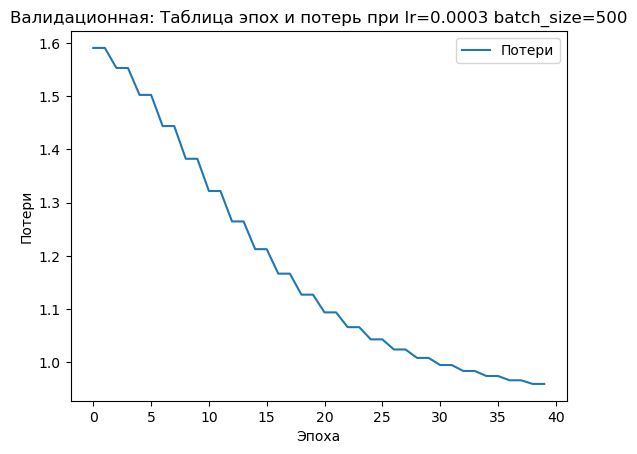

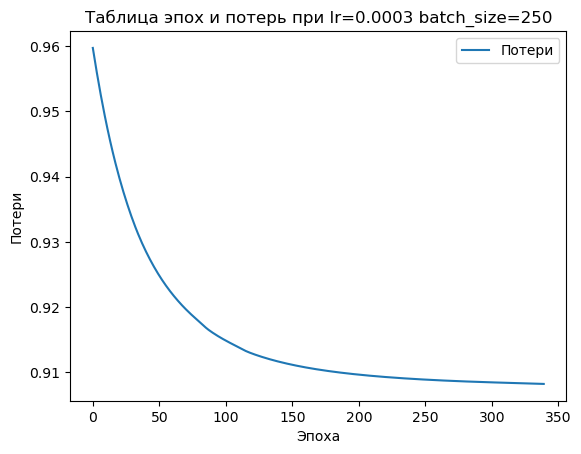

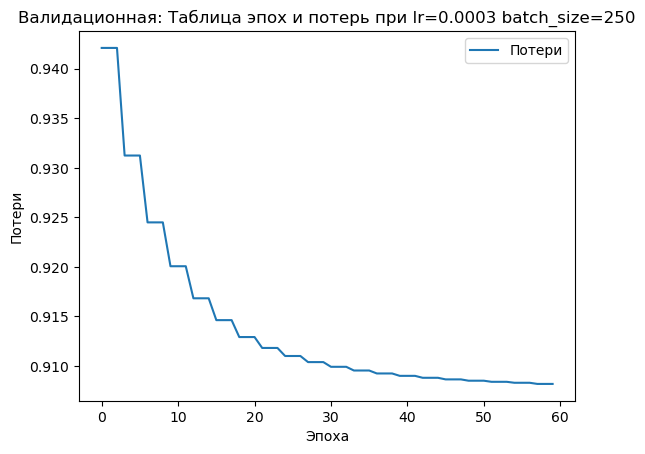

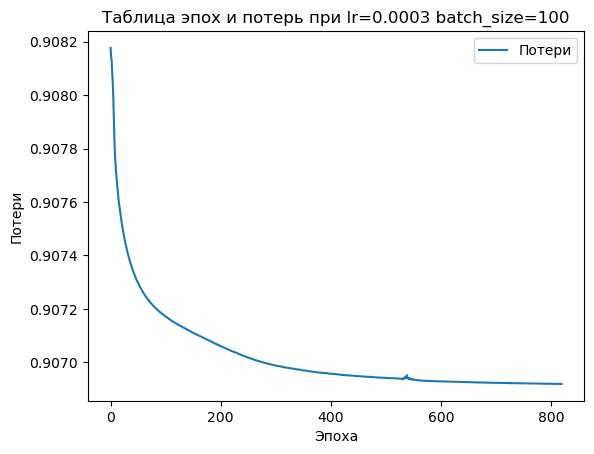

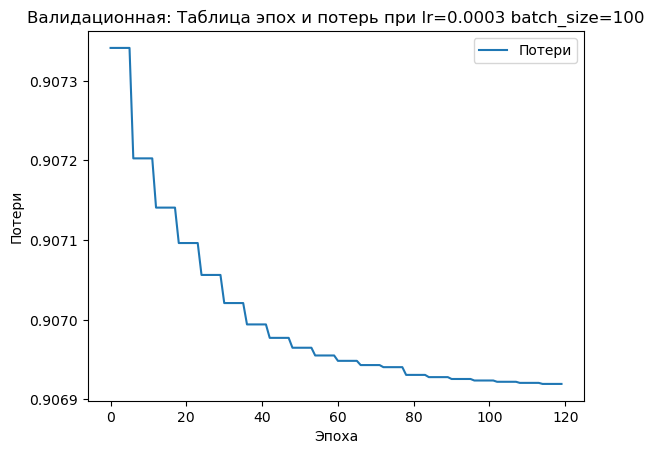

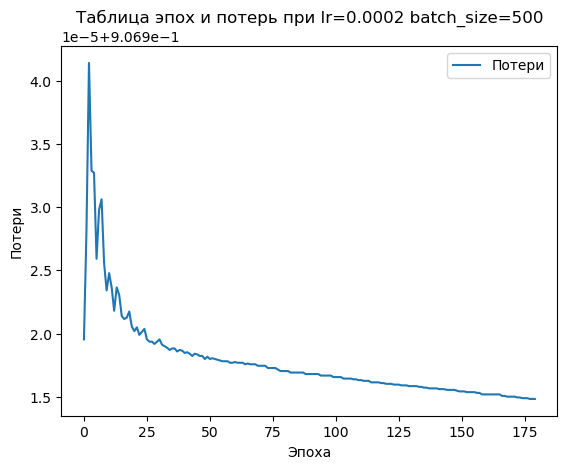

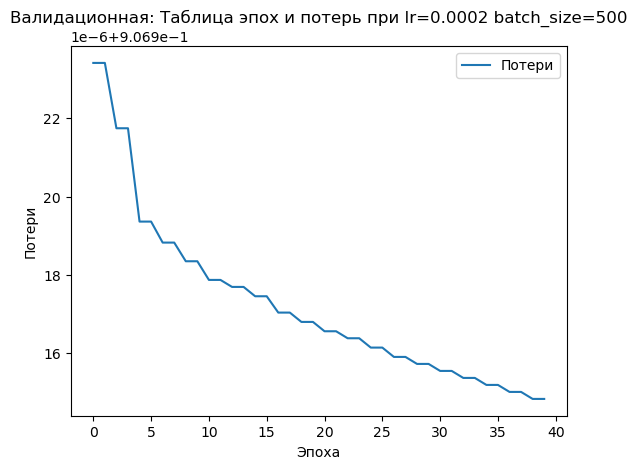

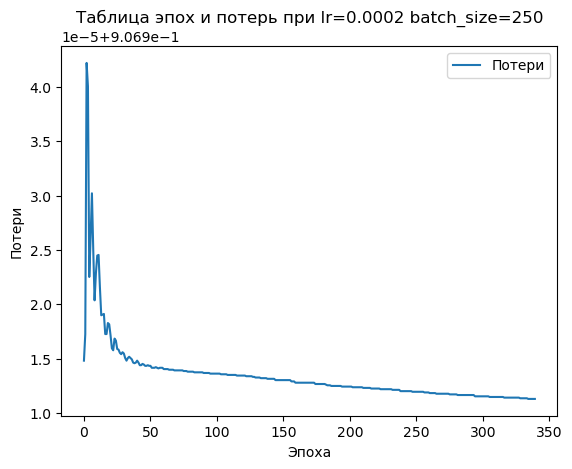

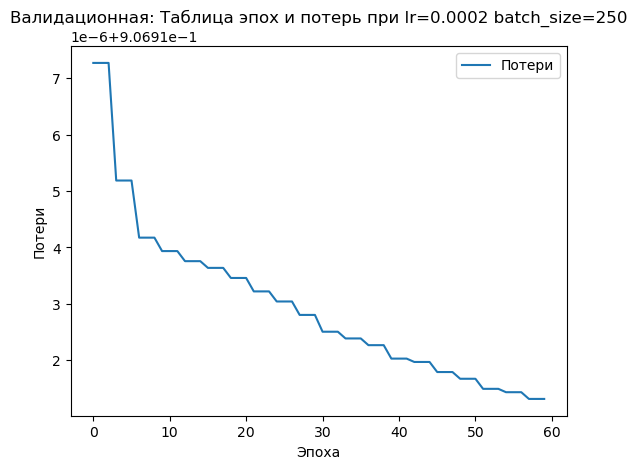

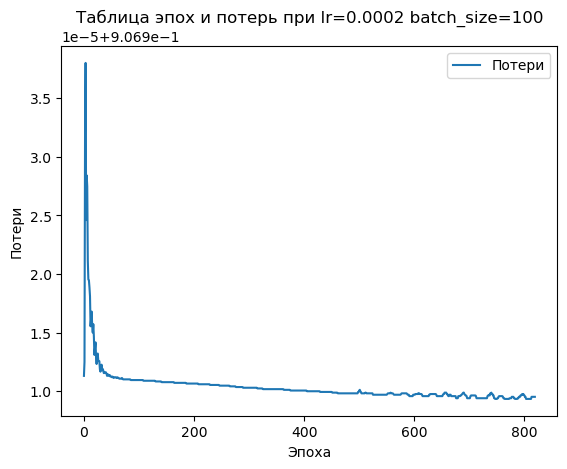

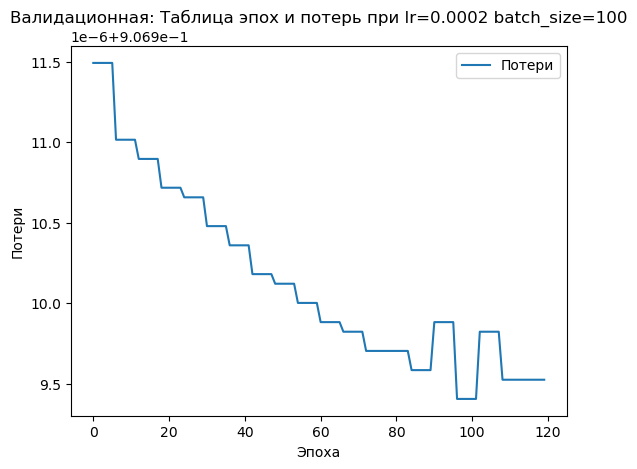

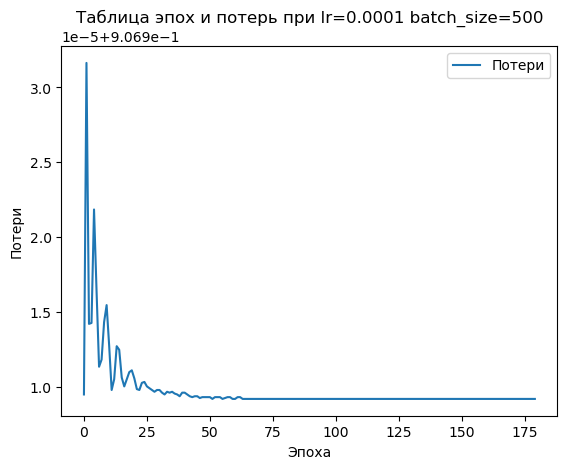

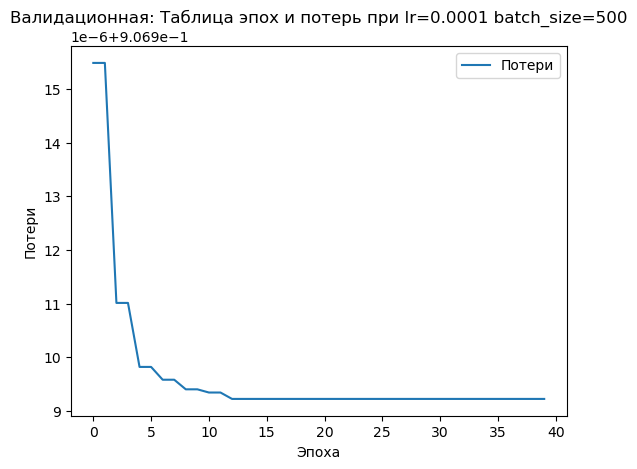

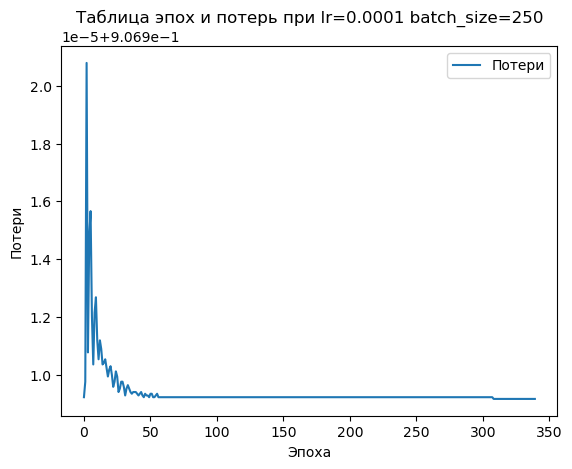

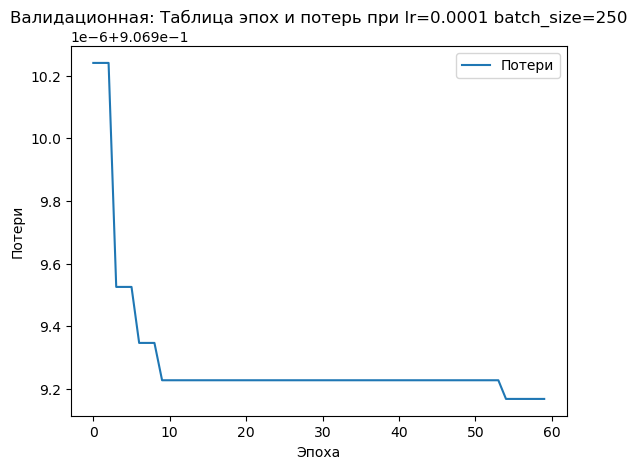

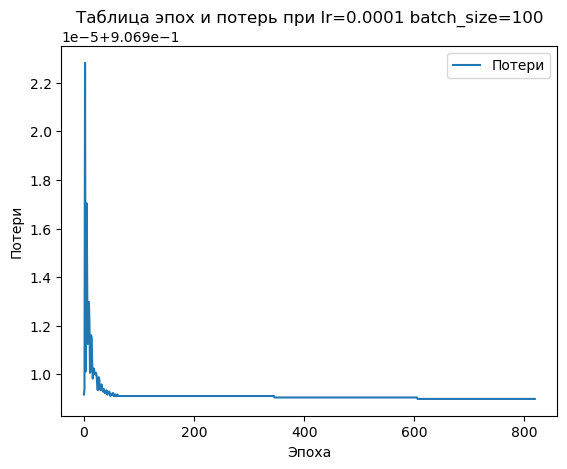

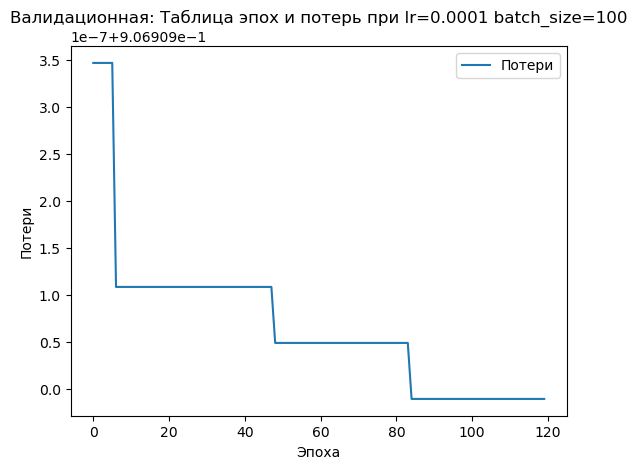

In [69]:
learning_rate = [0.0003, 0.0002, 0.0001]
batch_size = [500, 250, 100]
for lr in learning_rate:
  for bs in batch_size:
      data = torch.utils.data.DataLoader(x_train, batch_size=bs, shuffle=True)
      val_data = torch.utils.data.DataLoader(x_valid, batch_size=bs, shuffle=True)
      optimizer = torch.optim.Adam(params=model.parameters() , lr=lr)
      epochs = 20
      model.train()
      loss_test = []
      loss_val=[]
      for epoch in range(epochs):
       for elem in data:
        y_pred = model(x_train)
        loss = criterion(y_pred, y_train)
        loss_test.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
       model.eval()
       for elem in val_data:
         y_pred = model(x_train)
         loss = criterion(y_pred, y_train)
         loss_val.append(loss.item())
         
      plt.plot(loss_test)
      plt.title('Таблица эпох и потерь при lr='+str(lr) +" batch_size="+str(bs))
      plt.xlabel('Эпоха')
      plt.ylabel('Потери')
      plt.legend(['Потери'])
      plt.show()


      plt.plot(loss_val)
      plt.title('Валидационная: Таблица эпох и потерь при lr='+str(lr) +" batch_size="+str(bs))
      plt.xlabel('Эпоха')
      plt.ylabel('Потери')
      plt.legend(['Потери'])
      plt.show()
 

In [70]:
x_test = torch.Tensor(x_test).float()
y_test = torch.Tensor(y_test).long()
model.eval()
with torch.no_grad():
    for i in range(10):
        y_pred = model(x_test)
        loss = criterion(y_pred, y_test)
        pred = torch.max(y_pred, 1)[1].eq(y_test).sum()
    print("Accuracy : {}%".format(100 * pred / len(x_test)))

Accuracy : 34.599998474121094%


In [71]:
torch.save(model.state_dict(), r"C:\Users\natal\lab5\model.pt")

In [91]:
new_model = LogisticRegression()
new_model.load_state_dict(torch.load(r"C:\Users\natal\lab5\model.pt"))

<All keys matched successfully>

In [97]:
print(df["review"][3005])
new_review_vectorized = vectorizer.transform([df["review"][3005]]).toarray()
new_model.eval()
with torch.no_grad():
    pred_y = new_model(torch.Tensor(new_review_vectorized))
    print(pred_y)

испытание ждать четвёртый часть многотомный история начало получать подробный информация горгулья согласиться самый распространить фэнтези персонаж узнавать способность предназначение роль это мир открыться информация сколько дело остаться горгулья весьма неожиданный информация горгулья мочь панический атака знать сказать повод это всё понять зверь вскрыться неожиданный новость родственный связь знакомый персонаж точно неожиданный догадаться прочитать вместе персонаж пообывать двор ведьма ведьмак увидеть всё устроить узнать сила корона который охотиться король вампир читатель также ждать новость уза сопряжение появидеться стать причина появиться новый персонаж собственно дать ответ практически всё вопрос хватать информация предыдущий книга серия сюжет прежний насыщенный событие разный локацмя близкий финал герой ждать испытание аля форт боярд выжить удаться весь это спойлер автор предыдущий книга невозвратный потеря среди персонаж
tensor([[1.2222e-16, 2.6909e-09, 2.2006e-08, 1.0000e+00